# Energy Demand Forecasting with Granite Timeseries (TTM)

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.9" -U

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [13]:
import pandas as pd
from tsfm_public import (
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Download the data

We'll work with a dataset of hourly electrical demand, generation by type, prices, and weather in Spain.

1. Download the energy_data.csv.zip [dataset file from Kaggle here.](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)
2. Edit the `DATA_FILE_PATH` below to point to the data file.


In [14]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"

### Specify time and output variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [15]:
timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512

### Read in the data

We parse the csv into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a datetime.

In [33]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
  DATA_FILE_PATH,
  parse_dates=[timestamp_column], # Convert the timestamp column to datetime format. 
  date_format="%Y-%m-%d %H:%M:%S+%z", # Set the date format to match the timestamp column.
)
# print(input_df.iloc[2087:2100])

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Plot a segment of the target series

Here we inspect a preview of the target time series.

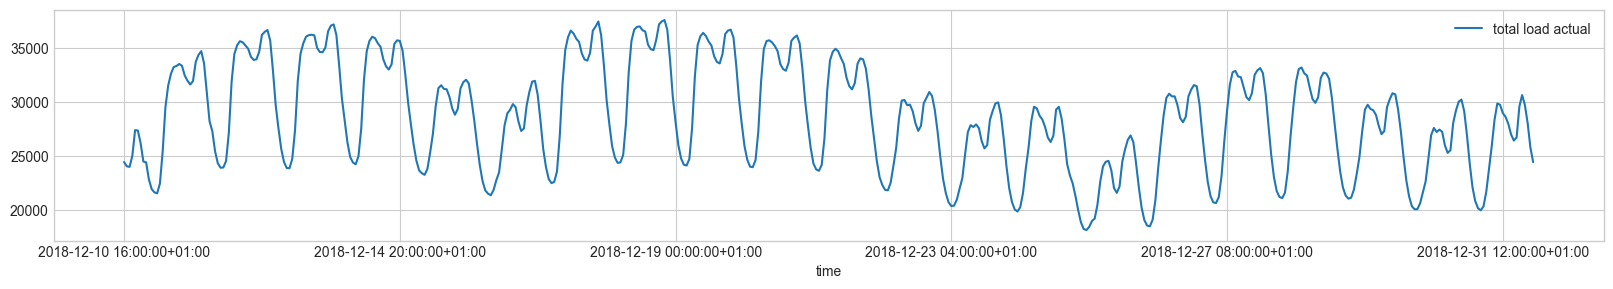

In [32]:
for target_column in target_columns:
  input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))


### Set up zero shot model
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.

In [7]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", # Name of the model on HuggingFace.
  num_input_channels=len(target_columns) # tsp.num_input_channels,
)

### Create a forecasting pipeline

Set up the forecasting pipeline with the model, setting `frequency` given our knowledge of the sample frequency. In this example we set `explode_forecasts` to `True`, which will format the output for plotting the history and prediction period. We then make a forecast on the dataset.

In [8]:
# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="h",
    device="cpu", # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

,time,total load actual_prediction
91,2019-01-04 19:00:00+01:00,31888.007812
92,2019-01-04 20:00:00+01:00,31953.996094
93,2019-01-04 21:00:00+01:00,31226.650391
94,2019-01-04 22:00:00+01:00,29632.423828
95,2019-01-04 23:00:00+01:00,27261.152344


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

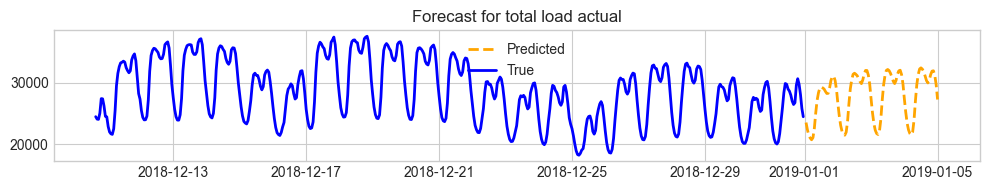

In [9]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=input_df,
    exploded_predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1],
    num_plots=1,
)